In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
plt.rcParams.update({'font.size': 15})

# Setting Up The FPGA

Install pychfpga from the stable branch, as of 8/19/24 use ian/dev branch with commit hash 

Before running any code, make sure you specify your board in the sifpga_crs_corr_capture.py. The call to CRS_CORR_CAPTURE at the end of the file should look like:
```
   1061 ccc = CRS_CORR_CAPTURE(hwm = 'crs 0032',
   1062                        stderr_log_level = 'debug',
   1063                        prog = 2,
   1064                        mode = 'corr8',
   1065                        make_directories = False,
   1066                        data_path = '/home/ih/d3a/rfsoc_data')
```   
 where you replace hwm = 'crs 0032' with your CRS board's serial number. If you are running this locally and not at DRAO, make sure to set the make_directories flag to false.

Run the line below with whatever path is correct for your local install for pychfpga. Point to the file called sifpga_crs_corr_capture.py

Some warnings are normal.

In [3]:
run /home/lmberkhout/src/pychfpga/pychfpga/sifpga_crs_corr_capture.py --verbose=False

Enabling nested event loop on current loop ID 137948072160272
Adding new log handlers of <Logger pychfpga (WARNING)> with level debug
Opened TCPipe socket at ('10.10.10.33', 55948)


There are no IceCrates in the hardware map!


+--------------+-----------------+
| Standalone   | Virt. slot None |
| Motherboards | CRS_SN0032      |
|              | 10.10.10.106    |
+--------------+-----------------+
| Mezz1        | -               |
| Mezz2        | -               |
+--------------+-----------------+

Forcing output 0 mode to LVPECL because fout is high
Forcing output 8 mode to LVPECL because fout is high
Forcing output 9 mode to LVPECL because fout is high
Forcing output 10 mode to LVPECL because fout is high
Forcing output 11 mode to LVPECL because fout is high
Forcing output 12 mode to LVPECL because fout is high
TCPipe: Programming FPGA with 34437356 bytes


chFPGA(None, 'CRS_SN0032'): Sync is not yet implemented on the CRS
chFPGA(None, 'CRS_SN0032'): Sync is not yet implemented on the CRS
chFPGA(None, 'CRS_SN0032'): There is no 1st CROSSBAR module in this firmware build (so there can't be data streamed to the correlators or GPU links!)
chFPGA(None, 'CRS_SN0032'): There is no 2nd CROSSBAR module in this firmware build
chFPGA(None, 'CRS_SN0032'): There is no 3rd CROSSBAR module in this firmware build
{self!r}: Cannot set data width on UCorn. Width is hardware fixed at 4+4i bits.Command is ignored. 
{self!r}: set_frames_per_packet is not implemented on UCorn. Packet size is set through the playlist. Command is ignored. 
The platform does not support SYNC sources
chFPGA(None, 'CRS_SN0032'): Sync is not yet implemented on the CRS
chFPGA(None, 'CRS_SN0032'): Sync is not yet implemented on the CRS
FPGAArray(1_boards,0_crates): SYNC will not be checked as not all firmware have SYNC logic
chFPGA(None, 'CRS_SN0032'): Sync is not yet implemented on 

-------------- CHAN[0].FFT STATUS --------------
 FFT Bypass: False
 FFT SHIFT schedule: 0x3FF8
 CASPER block pipeling delay: Measured=12533, set point=12533:  clocks
 Number of FFT overflows: 0
None
-------------- CHAN[1].FFT STATUS --------------
 FFT Bypass: False
 FFT SHIFT schedule: 0x3FF8
 CASPER block pipeling delay: Measured=12533, set point=12533:  clocks
 Number of FFT overflows: 0
None
-------------- CHAN[2].FFT STATUS --------------
 FFT Bypass: False
 FFT SHIFT schedule: 0x3FF8
 CASPER block pipeling delay: Measured=12533, set point=12533:  clocks
 Number of FFT overflows: 0
None
-------------- CHAN[3].FFT STATUS --------------
 FFT Bypass: False
 FFT SHIFT schedule: 0x3FF8
 CASPER block pipeling delay: Measured=12533, set point=12533:  clocks
 Number of FFT overflows: 0
None
-------------- CHAN[4].FFT STATUS --------------
 FFT Bypass: False
 FFT SHIFT schedule: 0x3FF8
 CASPER block pipeling delay: Measured=12533, set point=12533:  clocks
 Number of FFT overflows: 0
None


Calculate the number of seconds per sample to use later and label the board inputs. The board inputs are labelled for user convinience, you can relabel them to whatever is useful for you.

In [4]:
s_per_frame = 2**14*(1/(ccc.fs*1e6)) # samples/frame * seconds/sample. Make sure sampling frequency is in Hz
board_inputs = ['W6Y', 'W6X', 'E6Y', 'E6X', 'M6Y', 'M6X', 'Antenna1', 'Antenna 2'] 

# No Filter

Loop through each polarization and configure the FFT shift schedule. The shift defaulted here does 11 shifts at the first 11 stages of the FFT. 

In [5]:
for n in range(ccc.NPOLS):
    # Configure each FFT
    fft = ccc.i.chan[n].FFT
    fft.FFT_SHIFT = 0b00011111111111 #shift first 11 stages

Set the number of integrations and the number of captures. Number of integrations will be the number of spectra output, number of captures will set the integration time per spectra. The default here is 100 spectra with 10 integrations each.

In [6]:
n_fft_integrations = 100 # 
n_fft_captures = 10
fft_integration_period = 2*n_fft_captures*s_per_frame # we capture two contiguous frames at a time, so we recover twice as many frames as captures
print(fft_integration_period)

0.0001024


Capture the number of frames and integration time specified in the previous cell.

In [7]:
%%capture

psd_fft = np.zeros((n_fft_integrations, ccc.NPOLS, len(ccc.f)))
fft_cap_fft_ovflws = np.zeros((n_fft_integrations, ccc.NPOLS))

for n in range(n_fft_integrations):
    print(f'{n}/{n_fft_integrations}')
    
    # Pulse the overflows resets
    for m in range(ccc.NPOLS):
        # Reset FFT overflow counter
        ccc.i.chan[m].FFT.OVERFLOW_RESET = 1 
        ccc.i.chan[m].FFT.OVERFLOW_RESET = 0

    # Capture data
    d_fft = ccc.read_fft_frames(ncap = n_fft_captures, verbose=0)
    psd_fft[n] = np.mean(np.abs(d_fft)**2, axis = 1)
                
    # Measure FFT overflows
    fft_cap_fft_ovflws[n] = [ccc.i.chan[m].FFT.OVERFLOW_COUNT for m in range(ccc.NPOLS)]

Plot the first autospectra

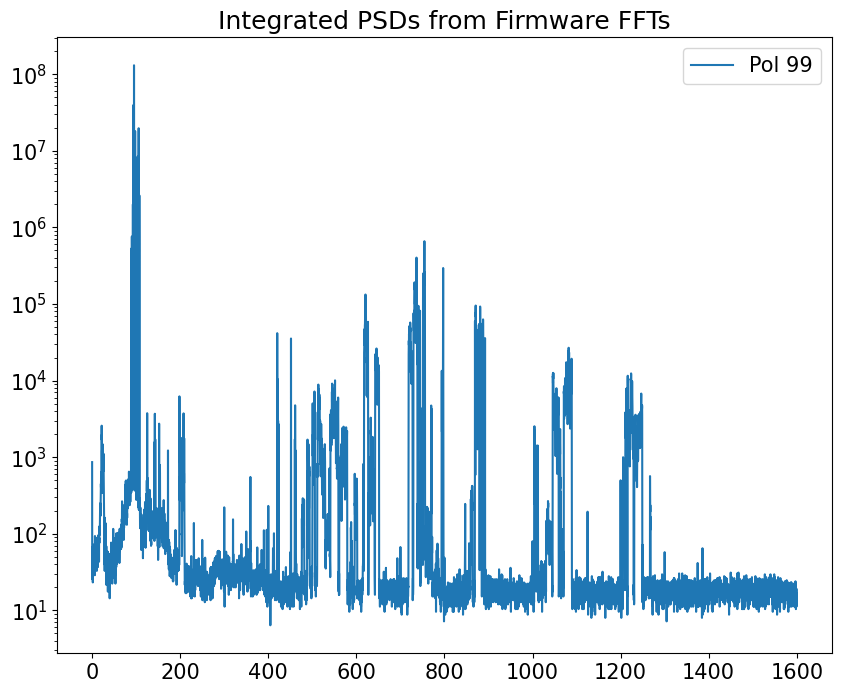

In [8]:
plt.figure(figsize = (10, 8))
plt.title('Integrated PSDs from Firmware FFTs')
plt.semilogy(ccc.f, psd_fft[0, 0], label = f'Pol {n}')
plt.legend()


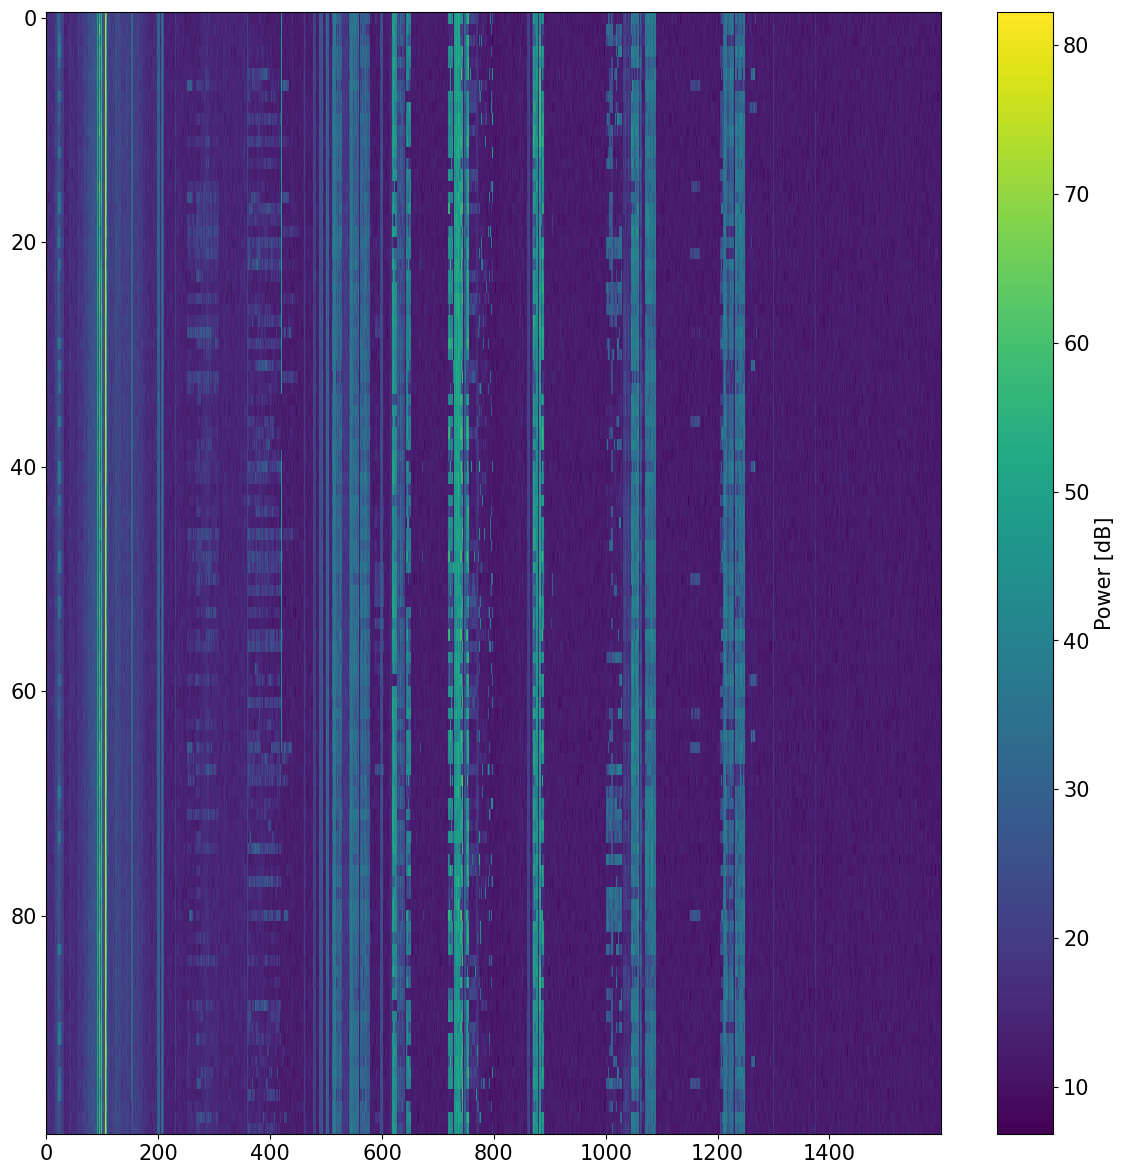

In [9]:
plt.figure(figsize = (12, 12))

plt.pcolormesh(ccc.f, np.arange(n_fft_integrations), 10*np.log10(psd_fft[:, 0, :]))
plt.colorbar(label = 'Power [dB]')
if n == 0 or n == 2 or n == 4 or n == 6:
    plt.ylabel('Integration')
if n == 6 or n== 7:
    plt.xlabel('Frequency [MHz]')
plt.gca().invert_yaxis()
plt.tight_layout()


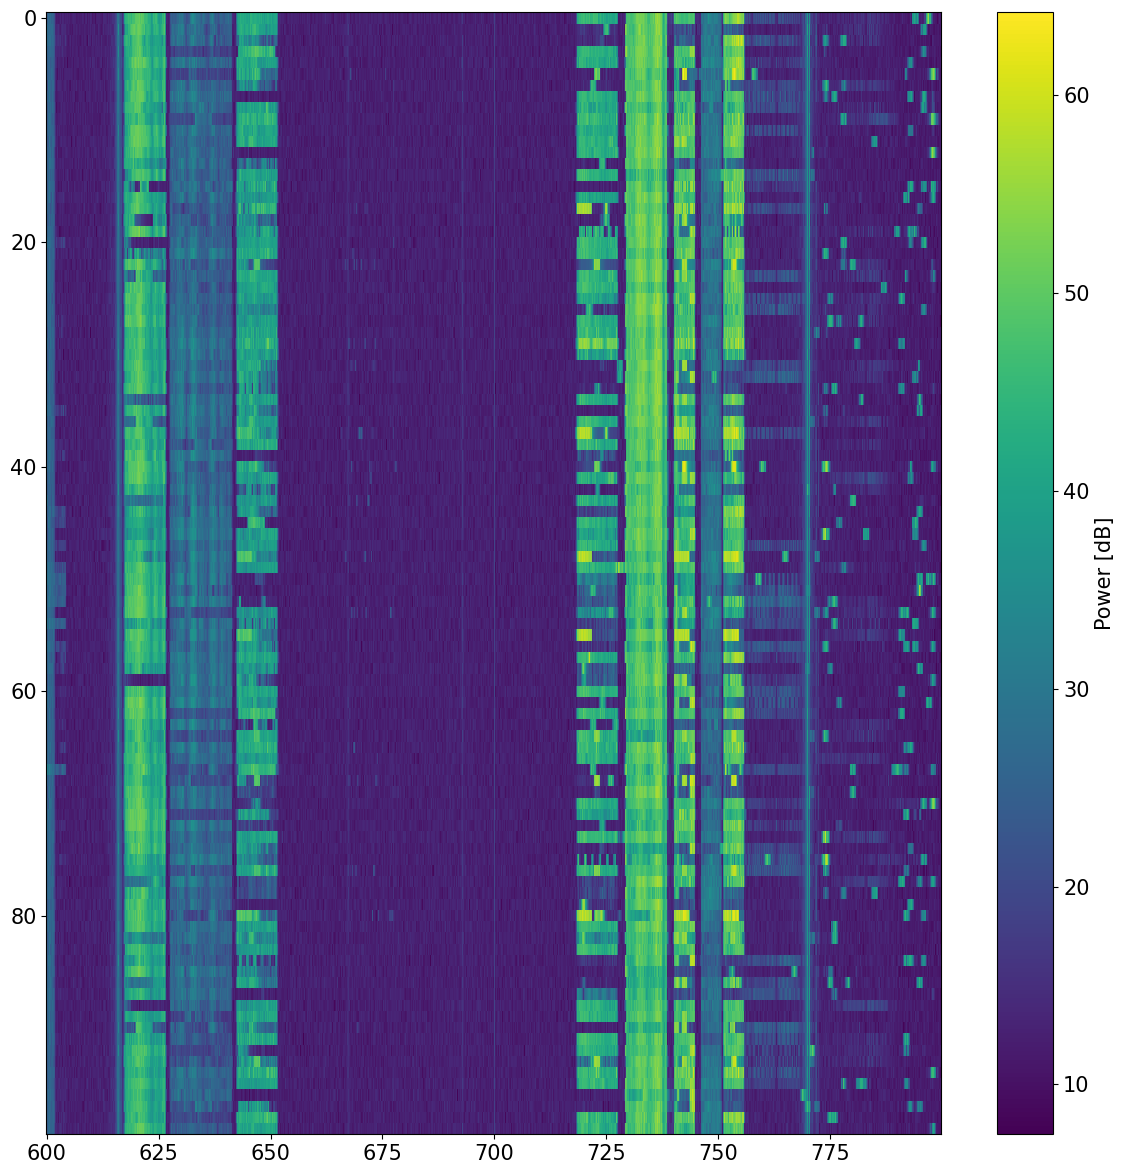

In [14]:
plt.figure(figsize = (12, 12))

plt.pcolormesh(ccc.f[3072:4096], np.arange(n_fft_integrations), 10*np.log10(psd_fft[:, 0, 3072:4096]))
plt.colorbar(label = 'Power [dB]')
if n == 0 or n == 2 or n == 4 or n == 6:
    plt.ylabel('Integration')
if n == 6 or n== 7:
    plt.xlabel('Frequency [MHz]')
plt.gca().invert_yaxis()
plt.tight_layout()

# Add 470-870 BPF

In [15]:
%%capture

psd_fft = np.zeros((n_fft_integrations, ccc.NPOLS, len(ccc.f)))
fft_cap_fft_ovflws = np.zeros((n_fft_integrations, ccc.NPOLS))

for n in range(n_fft_integrations):
    print(f'{n}/{n_fft_integrations}')
    
    # Pulse the overflows resets
    for m in range(ccc.NPOLS):
        # Reset FFT overflow counter
        ccc.i.chan[m].FFT.OVERFLOW_RESET = 1 
        ccc.i.chan[m].FFT.OVERFLOW_RESET = 0

    # Capture data
    d_fft = ccc.read_fft_frames(ncap = n_fft_captures, verbose=0)
    psd_fft[n] = np.mean(np.abs(d_fft)**2, axis = 1)
                
    # Measure FFT overflows
    fft_cap_fft_ovflws[n] = [ccc.i.chan[m].FFT.OVERFLOW_COUNT for m in range(ccc.NPOLS)]

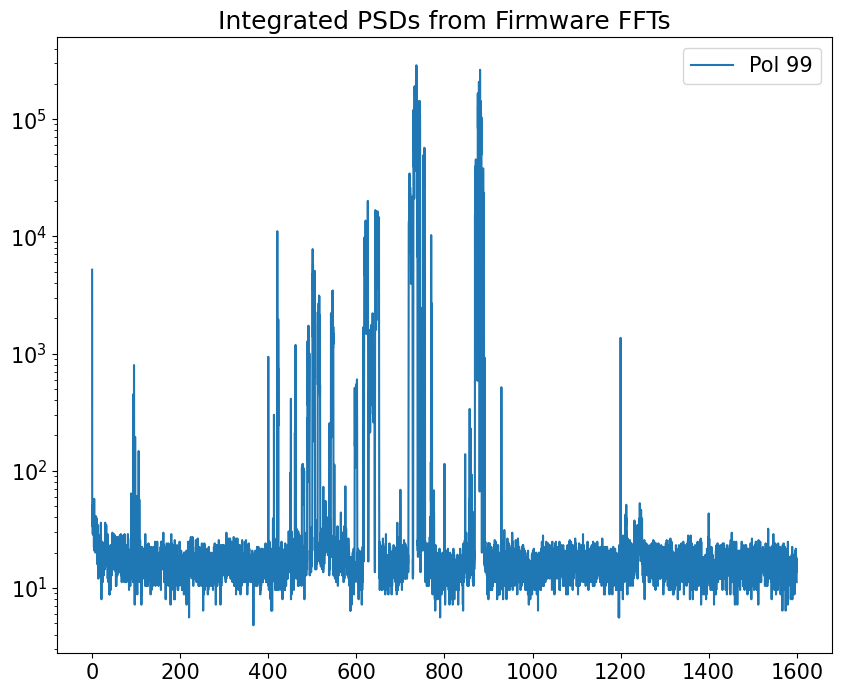

In [16]:
plt.figure(figsize = (10, 8))
plt.title('Integrated PSDs from Firmware FFTs')
plt.semilogy(ccc.f, psd_fft[0, 0], label = f'Pol {n}')
plt.legend()


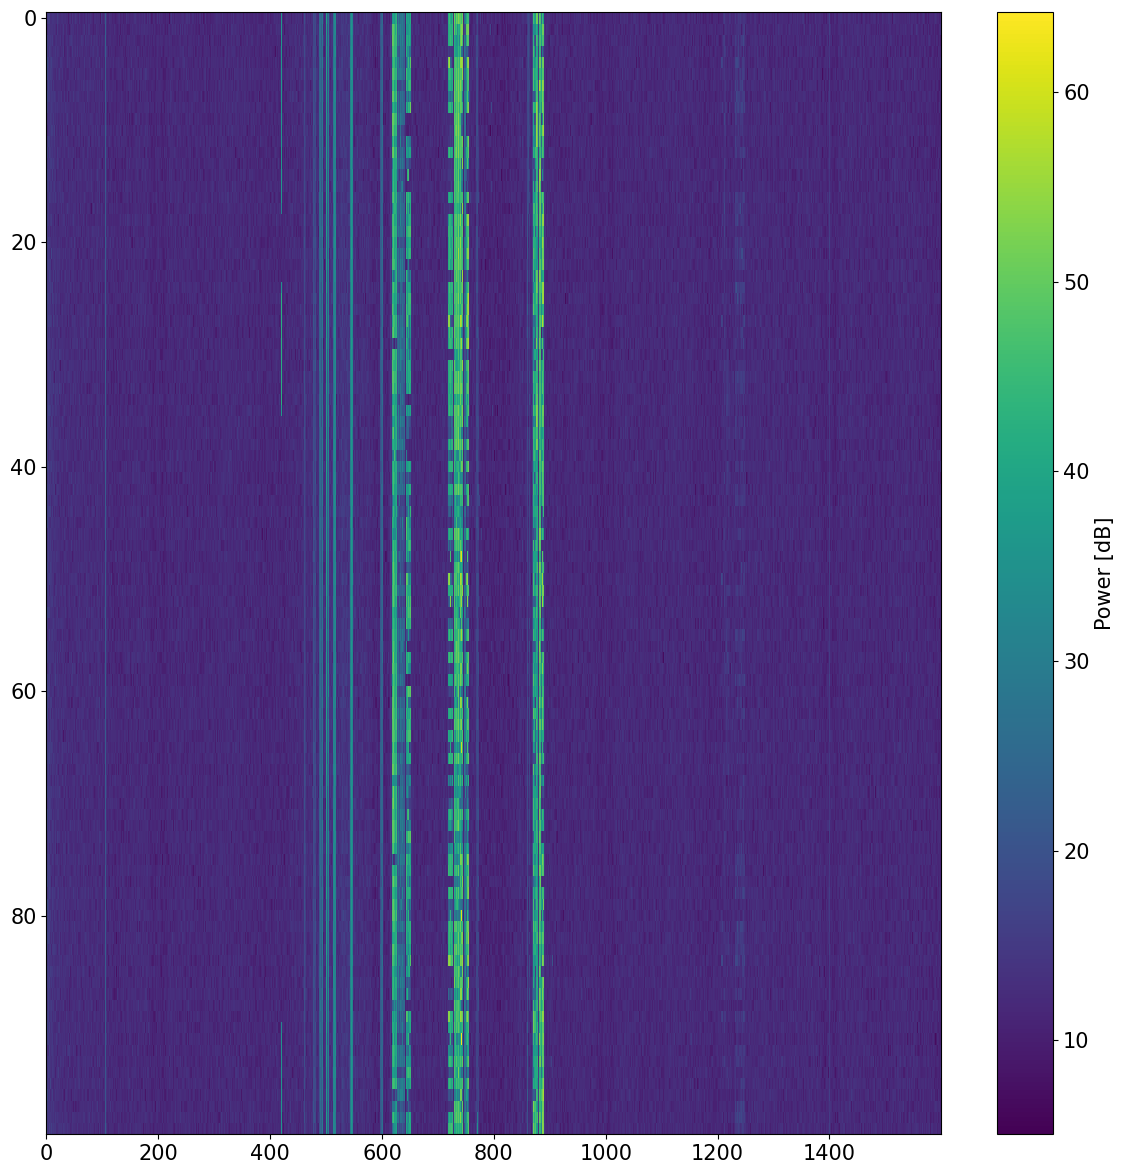

In [17]:
plt.figure(figsize = (12, 12))

plt.pcolormesh(ccc.f, np.arange(n_fft_integrations), 10*np.log10(psd_fft[:, 0, :]))
plt.colorbar(label = 'Power [dB]')
if n == 0 or n == 2 or n == 4 or n == 6:
    plt.ylabel('Integration')
if n == 6 or n== 7:
    plt.xlabel('Frequency [MHz]')
plt.gca().invert_yaxis()
plt.tight_layout()

# add 645 tight BPF

In [18]:
%%capture

psd_fft = np.zeros((n_fft_integrations, ccc.NPOLS, len(ccc.f)))
fft_cap_fft_ovflws = np.zeros((n_fft_integrations, ccc.NPOLS))

for n in range(n_fft_integrations):
    print(f'{n}/{n_fft_integrations}')
    
    # Pulse the overflows resets
    for m in range(ccc.NPOLS):
        # Reset FFT overflow counter
        ccc.i.chan[m].FFT.OVERFLOW_RESET = 1 
        ccc.i.chan[m].FFT.OVERFLOW_RESET = 0

    # Capture data
    d_fft = ccc.read_fft_frames(ncap = n_fft_captures, verbose=0)
    psd_fft[n] = np.mean(np.abs(d_fft)**2, axis = 1)
                
    # Measure FFT overflows
    fft_cap_fft_ovflws[n] = [ccc.i.chan[m].FFT.OVERFLOW_COUNT for m in range(ccc.NPOLS)]
    


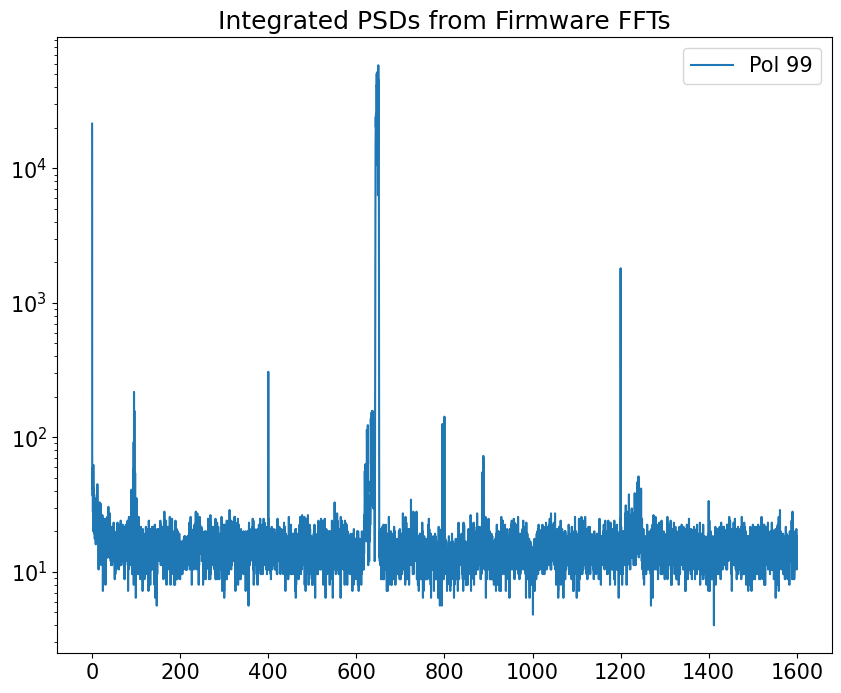

In [19]:
plt.figure(figsize = (10, 8))
plt.title('Integrated PSDs from Firmware FFTs')
plt.semilogy(ccc.f, psd_fft[0, 0], label = f'Pol {n}')
plt.legend()

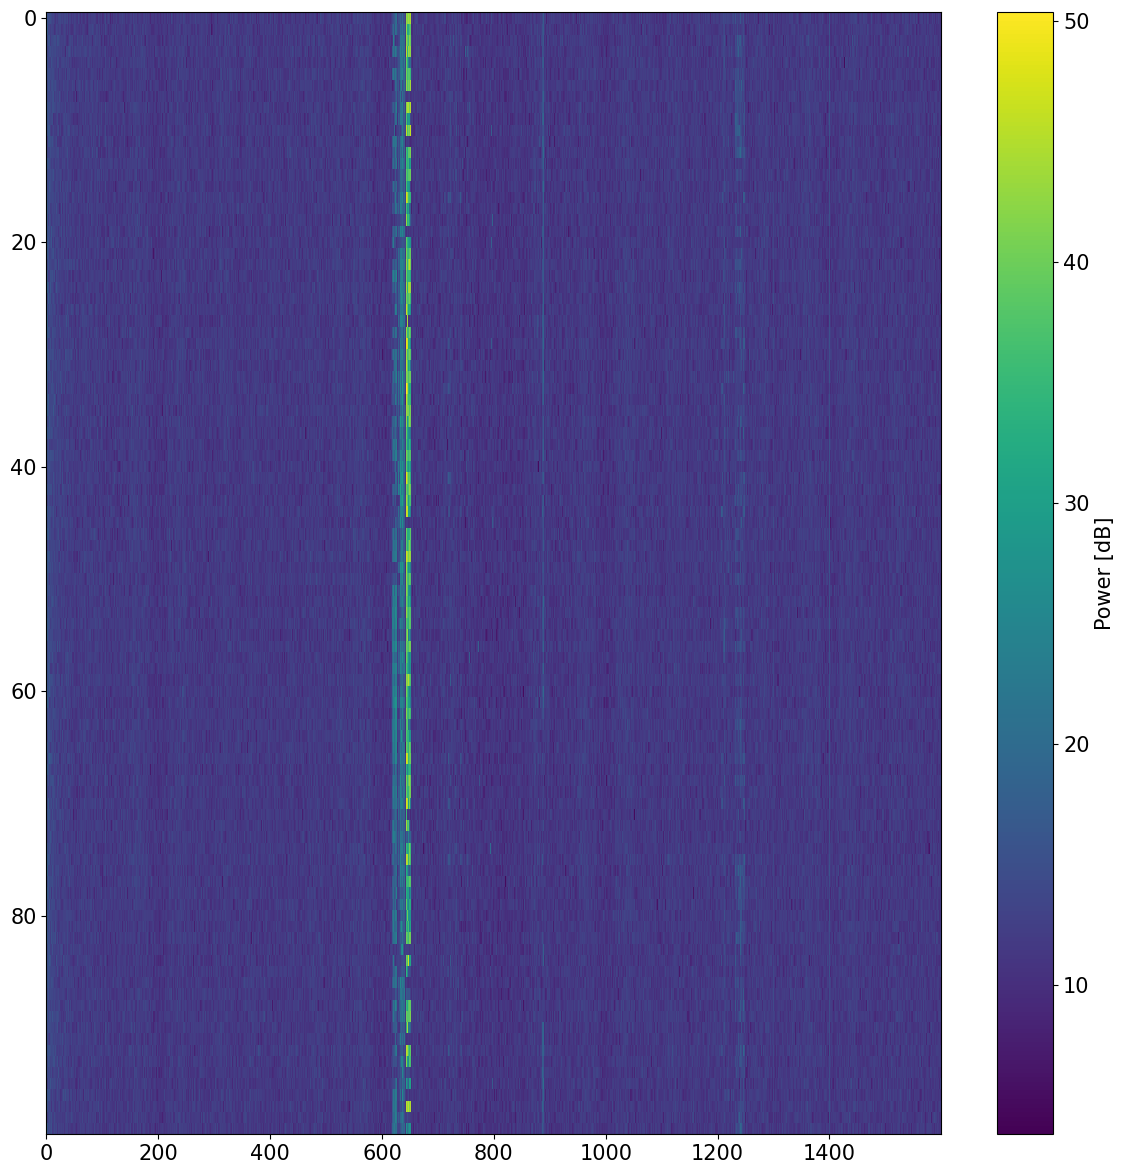

In [20]:
plt.figure(figsize = (12, 12))

plt.pcolormesh(ccc.f, np.arange(n_fft_integrations), 10*np.log10(psd_fft[:, 0, :]))
plt.colorbar(label = 'Power [dB]')
if n == 0 or n == 2 or n == 4 or n == 6:
    plt.ylabel('Integration')
if n == 6 or n== 7:
    plt.xlabel('Frequency [MHz]')
plt.gca().invert_yaxis()
plt.tight_layout()
